# house price prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.externals import joblib 
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer

import scipy.stats as stats
from scipy.stats import norm ,rankdata

from scipy.special import boxcox1p
from scipy.stats import normaltest
import statsmodels
import statsmodels.api as sm
from scipy.optimize import curve_fit

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PowerTransformer


from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb

In [2]:
df = pd.read_csv("housing_train.csv")
df.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7039061606,https://bham.craigslist.org/apa/d/birmingham-h...,birmingham,https://bham.craigslist.org,1195,apartment,1908,3,2.0,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00L0L_80pNkyDeG0...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
1,7041970863,https://bham.craigslist.org/apa/d/birmingham-w...,birmingham,https://bham.craigslist.org,1120,apartment,1319,3,2.0,1,...,0,0,0,laundry on site,off-street parking,https://images.craigslist.org/00707_uRrY9CsNMC...,Find Your Way to Haven Apartment Homes Come ho...,33.3755,-86.8045,al
2,7041966914,https://bham.craigslist.org/apa/d/birmingham-g...,birmingham,https://bham.craigslist.org,825,apartment,1133,1,1.5,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00h0h_b7Bdj1NLBi...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
3,7041966936,https://bham.craigslist.org/apa/d/birmingham-f...,birmingham,https://bham.craigslist.org,800,apartment,927,1,1.0,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00808_6ghZ8tSRQs...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
4,7041966888,https://bham.craigslist.org/apa/d/birmingham-2...,birmingham,https://bham.craigslist.org,785,apartment,1047,2,1.0,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00y0y_21c0FOvUXm...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al


In [3]:
print("Data Shape: "+str(df.shape))
print()
print("Columns: "+str(df.columns))
print()
print(df.info())

Data Shape: (265190, 22)

Columns: Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'description', 'lat',
       'long', 'state'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265190 entries, 0 to 265189
Data columns (total 22 columns):
id                         265190 non-null int64
url                        265190 non-null object
region                     265190 non-null object
region_url                 265190 non-null object
price                      265190 non-null int64
type                       265190 non-null object
sqfeet                     265190 non-null int64
beds                       265190 non-null int64
baths                      265190 non-null float64
cats_allowed               265190 non-null int64
dogs_allow

### Missing value counts

In [4]:
df.isnull().sum()

id                             0
url                            0
region                         0
region_url                     0
price                          0
type                           0
sqfeet                         0
beds                           0
baths                          0
cats_allowed                   0
dogs_allowed                   0
smoking_allowed                0
wheelchair_access              0
electric_vehicle_charge        0
comes_furnished                0
laundry_options            54311
parking_options            95135
image_url                      0
description                    2
lat                         1419
long                        1419
state                          1
dtype: int64

## 3- Region

## 2- Url

In [5]:
df.url[0]

'https://bham.craigslist.org/apa/d/birmingham-huge-three-bedroom-among-the/7039061606.html'

In [6]:
from urllib.parse import urlparse, parse_qs
from tqdm import tqdm
disc = {"url_parsed_loc": [], "url_params":[], "url_path_components": []}

for i in tqdm(range(df.shape[0]), position=0, leave=True):
    parsed = urlparse(df.url[i])
    disc["url_parsed_loc"].append(parsed.netloc)
    
    params = parse_qs(parsed.query)
    disc["url_params"].append(params)
    
    path_components = list(filter(bool, parsed.path.split('/')))
    disc["url_path_components"].append(path_components)

100%|███████████████████████████████████████████████████████████████████████| 265190/265190 [00:25<00:00, 10230.00it/s]


In [7]:
url_df = pd.DataFrame(disc)
print(url_df.url_params.value_counts())
url_df.head()

{}    265190
Name: url_params, dtype: int64


,url_parsed_loc,url_params,url_path_components
0,bham.craigslist.org,{},"[apa, d, birmingham-huge-three-bedroom-among-t..."
1,bham.craigslist.org,{},"[apa, d, birmingham-window-covering-dishwasher..."
2,bham.craigslist.org,{},"[apa, d, birmingham-garages-for-rent-at-100, 7..."
3,bham.craigslist.org,{},"[apa, d, birmingham-find-you-way-find-you-home..."
4,bham.craigslist.org,{},"[apa, d, birmingham-2-sparkling-swimming-pool-..."


In [8]:
url_df.drop("url_params", axis=1, inplace=True)
url_df.head()

,url_parsed_loc,url_path_components
0,bham.craigslist.org,"[apa, d, birmingham-huge-three-bedroom-among-t..."
1,bham.craigslist.org,"[apa, d, birmingham-window-covering-dishwasher..."
2,bham.craigslist.org,"[apa, d, birmingham-garages-for-rent-at-100, 7..."
3,bham.craigslist.org,"[apa, d, birmingham-find-you-way-find-you-home..."
4,bham.craigslist.org,"[apa, d, birmingham-2-sparkling-swimming-pool-..."


In [9]:
cnt=0
for i in tqdm(range(df.shape[0]), position=0, leave=True):
    if df["region_url"][i].find(url_df["url_parsed_loc"][i]) >= 0: 
        cnt+=1

print("Count: "+str(cnt))
print("Error rate: "+str(1-(cnt/df.shape[0])))

100%|███████████████████████████████████████████████████████████████████████| 265190/265190 [00:16<00:00, 16536.96it/s]


Count: 264783
Error rate: 0.0015347486707643077


In [10]:
#TODO: remove the useless colums here

## 16- Laundry Options

### Model based imputation (filling missing values)

In [11]:
#before imputation
print(df["laundry_options"].value_counts())
print(df["laundry_options"].isna().sum())

w/d in unit           91074
w/d hookups           50252
laundry on site       39186
laundry in bldg       27816
no laundry on site     2551
Name: laundry_options, dtype: int64
54311


In [12]:
from sklearn.neighbors import KNeighborsClassifier
decide_cols = ["beds", "baths", "cats_allowed", "dogs_allowed", 
               "smoking_allowed", "wheelchair_access", "electric_vehicle_charge",
               "comes_furnished", "price" ]

X_train = df[decide_cols][df["laundry_options"].isna()==False]
y_train = df["laundry_options"][df["laundry_options"].isna()==False]
X_test = df[decide_cols][df["laundry_options"].isna()==True]
 
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
laundry_pred = neigh.predict(X_test)
print(laundry_pred)
print(laundry_pred.size)

# filling missing values
df["laundry_options"][df["laundry_options"].isna()==True] = laundry_pred

['w/d in unit' 'w/d hookups' 'w/d in unit' ... 'laundry in bldg'
 'laundry on site' 'w/d in unit']
54311


In [13]:
#after imputation
print(df["laundry_options"].value_counts())
print(df["laundry_options"].isna().sum())

w/d in unit           112525
w/d hookups            64303
laundry on site        50051
laundry in bldg        35417
no laundry on site      2894
Name: laundry_options, dtype: int64
0


### One-hot Encoding for 5 categories

In [14]:
laundry_df = pd.get_dummies(df["laundry_options"], prefix="laundry")
print(laundry_df.shape)
laundry_df.head()

(265190, 5)


,laundry_laundry in bldg,laundry_laundry on site,laundry_no laundry on site,laundry_w/d hookups,laundry_w/d in unit
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


In [15]:
# add data to table
df = pd.concat([df, laundry_df], axis=1)
df = df.drop(["laundry_options"], axis=1)
df.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,image_url,description,lat,long,state,laundry_laundry in bldg,laundry_laundry on site,laundry_no laundry on site,laundry_w/d hookups,laundry_w/d in unit
0,7039061606,https://bham.craigslist.org/apa/d/birmingham-h...,birmingham,https://bham.craigslist.org,1195,apartment,1908,3,2.0,1,...,https://images.craigslist.org/00L0L_80pNkyDeG0...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al,0,1,0,0,0
1,7041970863,https://bham.craigslist.org/apa/d/birmingham-w...,birmingham,https://bham.craigslist.org,1120,apartment,1319,3,2.0,1,...,https://images.craigslist.org/00707_uRrY9CsNMC...,Find Your Way to Haven Apartment Homes Come ho...,33.3755,-86.8045,al,0,1,0,0,0
2,7041966914,https://bham.craigslist.org/apa/d/birmingham-g...,birmingham,https://bham.craigslist.org,825,apartment,1133,1,1.5,1,...,https://images.craigslist.org/00h0h_b7Bdj1NLBi...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al,0,1,0,0,0
3,7041966936,https://bham.craigslist.org/apa/d/birmingham-f...,birmingham,https://bham.craigslist.org,800,apartment,927,1,1.0,1,...,https://images.craigslist.org/00808_6ghZ8tSRQs...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al,0,1,0,0,0
4,7041966888,https://bham.craigslist.org/apa/d/birmingham-2...,birmingham,https://bham.craigslist.org,785,apartment,1047,2,1.0,1,...,https://images.craigslist.org/00y0y_21c0FOvUXm...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al,0,1,0,0,0


## 17- Parking Options

### Model based imputation (filling missing values)

In [16]:
#before imputation
print(df["parking_options"].value_counts())
print(df["parking_options"].isna().sum())

off-street parking    88316
carport               28685
attached garage       27591
detached garage       12798
street parking        10570
no parking             1973
valet parking           122
Name: parking_options, dtype: int64
95135


In [17]:
from sklearn.neighbors import KNeighborsClassifier
decide_cols = ["beds", "baths", "cats_allowed", "dogs_allowed", 
               "smoking_allowed", "wheelchair_access", "electric_vehicle_charge",
               "comes_furnished", "price" ]

X_train = df[decide_cols][df["parking_options"].isna()==False]
y_train = df["parking_options"][df["parking_options"].isna()==False]
X_test = df[decide_cols][df["parking_options"].isna()==True]
 
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(X_train, y_train)
laundry_pred = neigh.predict(X_test)
print(laundry_pred)
print(laundry_pred.size)

# filling missing values
df["parking_options"][df["parking_options"].isna()==True] = laundry_pred

['off-street parking' 'attached garage' 'off-street parking' ...
 'off-street parking' 'off-street parking' 'attached garage']
95135


In [18]:
#after imputation
print(df["parking_options"].value_counts())
print(df["parking_options"].isna().sum())

off-street parking    144939
carport                46040
attached garage        41132
detached garage        16715
street parking         13694
no parking              2542
valet parking            128
Name: parking_options, dtype: int64
0


### One-hot Encoding for 7 categories

In [19]:
parking_df = pd.get_dummies(df["parking_options"], prefix="parking")
print(parking_df.shape)
parking_df.head()

(265190, 7)


,parking_attached garage,parking_carport,parking_detached garage,parking_no parking,parking_off-street parking,parking_street parking,parking_valet parking
0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0


In [20]:
# add data to table
df = pd.concat([df, parking_df], axis=1)
df = df.drop(["parking_options"], axis=1)
df.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,laundry_no laundry on site,laundry_w/d hookups,laundry_w/d in unit,parking_attached garage,parking_carport,parking_detached garage,parking_no parking,parking_off-street parking,parking_street parking,parking_valet parking
0,7039061606,https://bham.craigslist.org/apa/d/birmingham-h...,birmingham,https://bham.craigslist.org,1195,apartment,1908,3,2.0,1,...,0,0,0,0,0,0,0,0,1,0
1,7041970863,https://bham.craigslist.org/apa/d/birmingham-w...,birmingham,https://bham.craigslist.org,1120,apartment,1319,3,2.0,1,...,0,0,0,0,0,0,0,1,0,0
2,7041966914,https://bham.craigslist.org/apa/d/birmingham-g...,birmingham,https://bham.craigslist.org,825,apartment,1133,1,1.5,1,...,0,0,0,0,0,0,0,0,1,0
3,7041966936,https://bham.craigslist.org/apa/d/birmingham-f...,birmingham,https://bham.craigslist.org,800,apartment,927,1,1.0,1,...,0,0,0,0,0,0,0,0,1,0
4,7041966888,https://bham.craigslist.org/apa/d/birmingham-2...,birmingham,https://bham.craigslist.org,785,apartment,1047,2,1.0,1,...,0,0,0,0,0,0,0,0,1,0


## 20, 21- Latitude and Longitude

In [21]:
df.dropna(inplace=True)
df.shape

(263769, 32)

In [22]:
from sklearn.cluster import KMeans

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:57<00:00, 11.89s/it]


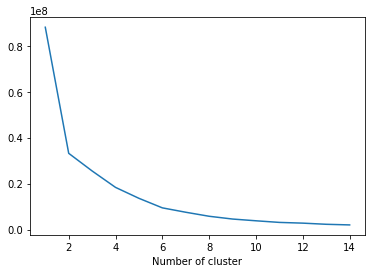

In [23]:
from sklearn.cluster import KMeans

sse={}
lat_long_df = df[['lat', 'long']]

for k in tqdm(range(1, 15), position=0, leave=True):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(lat_long_df)
    lat_long_df["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [24]:
kmeans = KMeans(n_clusters=12, random_state=0)

lat_long_pred = kmeans.fit_predict(df[["lat", "long"]])
print(kmeans.labels_)
print(lat_long_pred.size)

[11 11 11 ...  8  8  8]
263769


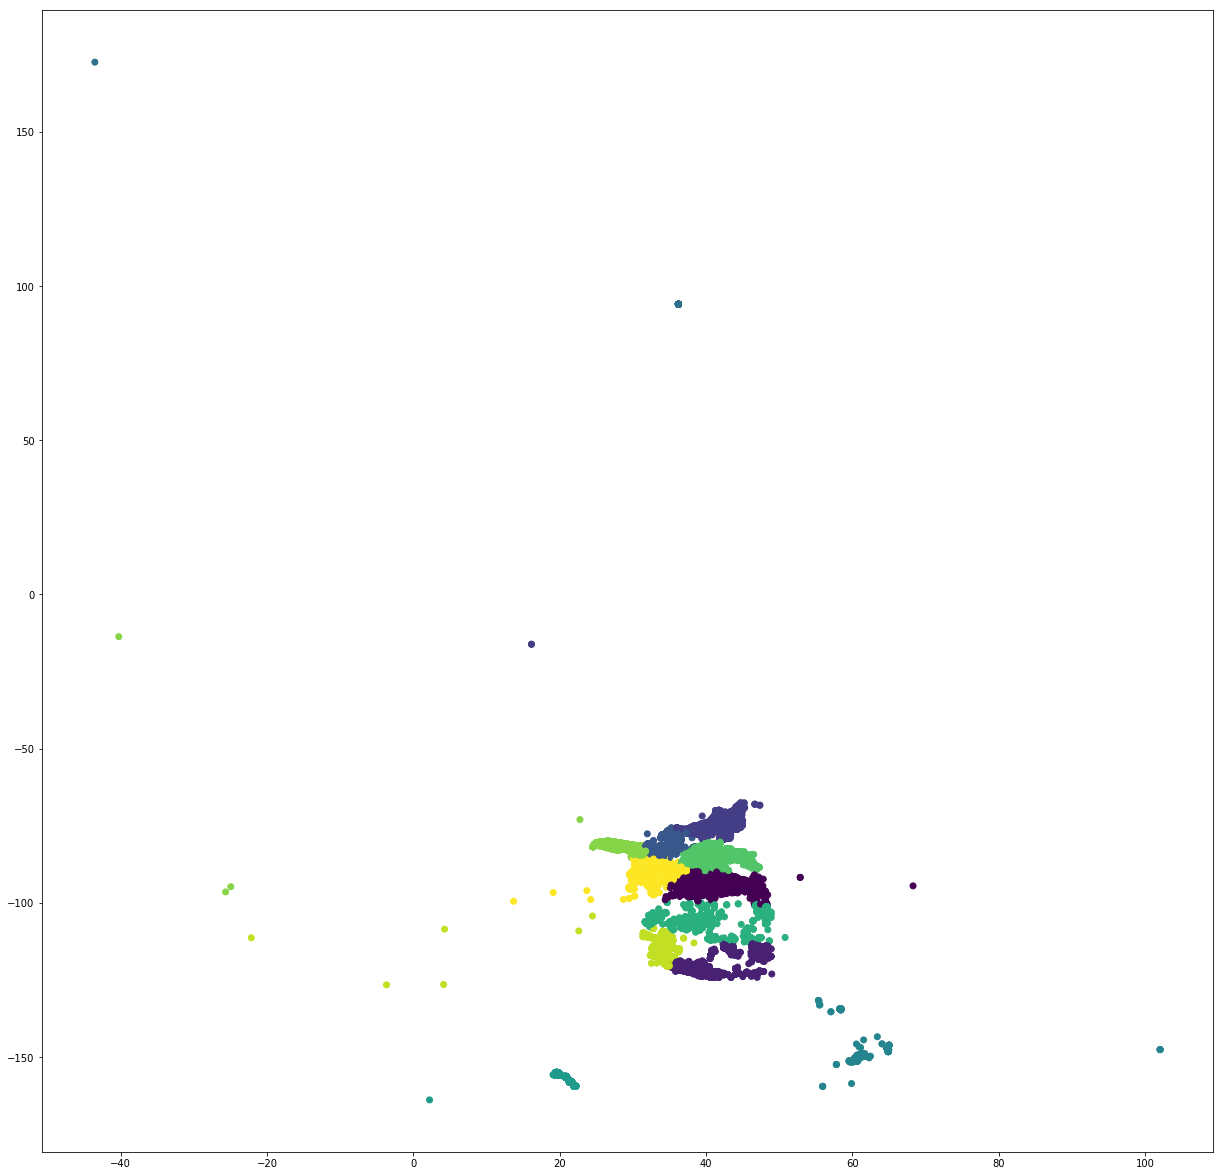

In [25]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(21,21))
plt.scatter(x=df['lat'], y=df['long'], c=lat_long_pred)
plt.show()

In [26]:
# add data to table

lat_long_df = pd.DataFrame(lat_long_pred, columns=["lat_long_cluster"])
print(lat_long_df.shape)


df = pd.concat([df, lat_long_df], axis=1)
df = df.drop(["lat", "long"], axis=1)
df.head()

(263769, 1)


,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,laundry_w/d hookups,laundry_w/d in unit,parking_attached garage,parking_carport,parking_detached garage,parking_no parking,parking_off-street parking,parking_street parking,parking_valet parking,lat_long_cluster
0,7.039062e+09,https://bham.craigslist.org/apa/d/birmingham-h...,birmingham,https://bham.craigslist.org,1195.0,apartment,1908.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0
1,7.041971e+09,https://bham.craigslist.org/apa/d/birmingham-w...,birmingham,https://bham.craigslist.org,1120.0,apartment,1319.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.0
2,7.041967e+09,https://bham.craigslist.org/apa/d/birmingham-g...,birmingham,https://bham.craigslist.org,825.0,apartment,1133.0,1.0,1.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0
3,7.041967e+09,https://bham.craigslist.org/apa/d/birmingham-f...,birmingham,https://bham.craigslist.org,800.0,apartment,927.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0
4,7.041967e+09,https://bham.craigslist.org/apa/d/birmingham-2...,birmingham,https://bham.craigslist.org,785.0,apartment,1047.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0


## 19- Description

In [41]:
i=1451
print(df.description[i])

Country Lane Apartment HomesRENT: $785 / MONTH SIZE: 550 sq ft  BEDROOMS: 1 BATHROOMS: 1 LEASE TERMS: Monthly show contact info UNIT FEATURES:   ** Balcony** Walk-In Closets** Range** HeatingCountry Lane Apartments are located in midtown Anchorage, off Old Seward and E.42nd avenue. Getting around is easy - we're on two main bus routes that travel to almost all sides of Anchorage.  Country Lane is a vintage building, with the benefits of spacious apartments. The back ranch-style buildings feature ground level walk-up apartment homes with front and back yard areas. Perfect for pets - cats and dogs are welcome!PROPERTY FEATURES ** Laundry Facility** Pet Friendly** Maintenance on site** Some Paid Utilities** Double Closets** On Site Management** Interior Hallways** Public Yard & Pet Areas** Midtown Location** Balconies** On The Bus Route  PET POLICY: Cat(s);Dog(s);Breed Restriction;Pet friendly. 2 pets per apartment either cat or dog. Breed and weight restrictions apply. Call for details. 

In [44]:
from bs4 import BeautifulSoup
import re

In [47]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [45]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [46]:
def clean_text(sentance):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    return sentance.strip()

In [ ]:
for i in tqdm(range(loop), position=0, leave=True):
    df.description[i] = clean_text(df.description[i])

 12%|█████████▎                                                                     | 177/1500 [00:35<04:21,  5.06it/s]

In [40]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
sid_obj = SentimentIntensityAnalyzer()

description_dict = {"description_negative":[], "description_neutral": [], "description_positive":[]}


# loop = df.shape[0]
loop1, loop2 = 1400, 1500
for i in tqdm(range(loop1, loop2), position=0, leave=True):
    desc = df.description[i]
    sentiment_dict = sid_obj.polarity_scores(desc) 
    description_dict["description_negative"].append(sentiment_dict["neg"])
    description_dict["description_neutral"].append(sentiment_dict["neu"])
    description_dict["description_positive"].append(sentiment_dict["pos"])

 44%|███████████████████████████████████▏                                            | 44/100 [00:00<00:00, 215.28it/s]


TypeError: 'float' object is not iterable

In [29]:
df.shape[0]

265189

In [ ]:
desc_df = pd.DataFrame(description_dict)
print(desc_df.shape)
desc_df.head()

In [ ]:
# add data to table

description_df = pd.DataFrame(lat_long_pred, columns=["lat_long_cluster"])
print(description_df.shape)

df = pd.concat([df, desc_df], axis=1)
df = df.drop(["description"], axis=1)
df.head()

In [ ]:
df.isnull().sum()

  1%|▍                                                                          | 1448/265189 [00:30<27:00, 162.73it/s]